<a href="https://colab.research.google.com/github/MySureStart/spring_2023_vail-Mennatullah-Elsahy/blob/main/Day_10/Regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

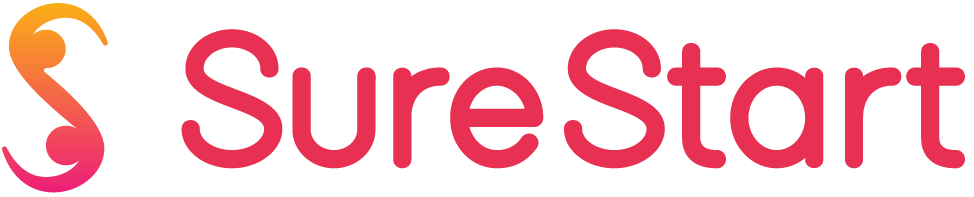

#Day 10 Objectives:
* To acquaint you with the problem of overfit models and to mitigate it with regularization

# Applying regularization

You may be familiar with Occam's Razor principle: given two explanations for something, the explanation most likely to be correct is the "simplest" one, the one that makes the least amount of assumptions. This also applies to the models learned by neural networks: given some training data and a network architecture, there are multiple sets of weights values (multiple models) that could explain the data, and simpler models are less likely to overfit than complex ones.

A "simple model" in this context is a model where the distribution of parameter values has less entropy (or a model with fewer parameters altogether, as we saw in the section above). Thus a common way to mitigate overfitting is to put constraints on the complexity of a network by forcing its weights only to take small values, which makes the distribution of weight values more "regular". This is called "weight regularization", and it is done by adding to the loss function of the network a cost associated with having large weights. This cost comes in two flavors:

L1 regularization, where the cost added is proportional to the absolute value of the weights coefficients (i.e. to what is called the "L1 norm" of the weights).

L2 regularization, where the cost added is proportional to the square of the value of the weights coefficients (i.e. to what is called the squared "L2 norm" of the weights). L2 regularization is also called weight decay in the context of neural networks. Don't let the different name confuse you: weight decay is mathematically the exact same as L2 regularization.

L1 regularization pushes weights towards exactly zero encouraging a sparse model. L2 regularization will penalize the weights parameters without making them sparse since the penalty goes to zero for small weights-one reason why L2 is more common.

In `tf.keras`, weight regularization is added by passing weight regularizer instances to layers as keyword arguments. Let's add L2 weight regularization now.


In [1]:
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import regularizers


NB_WORDS = 10000  # Parameter indicating the number of words we'll put in the dictionary
NB_START_EPOCHS = 20  # Number of epochs we usually start to train with
BATCH_SIZE = 512  # Size of the batches used in the mini-batch gradient descent
MAX_LEN = 20  # Maximum number of words in a sequence


# Define the model
reg_model = models.Sequential()
reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=(NB_WORDS,)))
reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
reg_model.add(layers.Dense(3, activation='softmax'))

# Print the model summary
reg_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                640064    
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 3)                 195       
                                                                 
Total params: 644,419
Trainable params: 644,419
Non-trainable params: 0
_________________________________________________________________


In [2]:
def deep_model(model, X_train, y_train, X_valid, y_valid):
    model.compile(optimizer='rmsprop'
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy'])
    
    history = model.fit(X_train
                       , y_train
                       , epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , validation_data=(X_valid, y_valid)
                       , verbose=1)
    return history
     

In [3]:
def optimal_epoch(model_hist):
  min_epoch = np.argmin(model_hist.history['val_loss']) + 1
  print("Minimum validation loss reached in epoch {}".format(min_epoch))
  return min_epoch

In [4]:
def remove_mentions(input_text):
  return re.sub(r'@\w+', '', input_text)

In [5]:
def remove_stopwords(input_text):
  stopwords_list = stopwords.words('english')
  # Some words which might indicate a certain sentiment are kept via a whitelist
  whitelist = ["n't", "not", "no"]
  words = input_text.split() 
  clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
  return " ".join(clean_words) 

In [6]:
def eval_metric(model, history, metric_name):
  metric = history.history[metric_name]
  val_metric = history.history['val_' + metric_name]

  e = range(1, NB_START_EPOCHS + 1)

  plt.plot(e, metric, 'bo', label='Train ' + metric_name)
  plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
  plt.xlabel('Epoch number')
  plt.ylabel(metric_name)
  plt.title('Comparing training and validation ' + metric_name + ' for ' + model.name)
  plt.legend()
  plt.show()

In [7]:
def compare_models_by_metric(model_1, model_2, model_hist_1, model_hist_2, metric):
  metric_model_1 = model_hist_1.history[metric]
  metric_model_2 = model_hist_2.history[metric]

  e = range(1, NB_START_EPOCHS + 1)
    
  metrics_dict = {
        'acc' : 'Training Accuracy',
        'loss' : 'Training Loss',
        'val_acc' : 'Validation accuracy',
        'val_loss' : 'Validation loss'
    }
    
  metric_label = metrics_dict[metric]

  plt.plot(e, metric_model_1, 'bo', label=model_1.name)
  plt.plot(e, metric_model_2, 'b', label=model_2.name)
  plt.xlabel('Epoch number')
  plt.ylabel(metric_label)
  plt.title('Comparing ' + metric_label + ' between models')
  plt.legend()
  plt.show()   

In [8]:
from pathlib import Path
root = Path('../content/')
input_path = root / 'input/' 
ouput_path = root / 'output/'
source_path = root / 'source/'

In [9]:
! gdown --id 1QFupRVBpstzf_D6NiFvYQIO-MPuiwG9u 
! mkdir input/ 
! mv Tweets.csv input/

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1QFupRVBpstzf_D6NiFvYQIO-MPuiwG9u
To: /content/Tweets.csv
100% 3.42M/3.42M [00:00<00:00, 167MB/s]
mkdir: cannot create directory ‘input/’: File exists


In [10]:
import re
import collections
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
import pandas as pd 
import numpy as np
# Packages for data preparation
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
df = pd.read_csv(input_path / 'Tweets.csv')
df = df.reindex(np.random.permutation(df.index))  
df = df[['text', 'airline_sentiment']]
df.text = df.text.apply(remove_stopwords).apply(remove_mentions)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
reg_model = models.Sequential()
reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=(NB_WORDS,)))
reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
reg_model.add(layers.Dense(3, activation='softmax'))
reg_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                640064    
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 3)                 195       
                                                                 
Total params: 644,419
Trainable params: 644,419
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Packages for data preparation
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(df.text, df.airline_sentiment, test_size=0.1, random_state=37)
print('# Train data samples:', X_train.shape[0])
print('# Test data samples:', X_test.shape[0])
assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]


# Train data samples: 13176
# Test data samples: 1464


In [13]:

tk = Tokenizer(num_words=NB_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~\t\n',
               lower=True,
               char_level=False,
               split=' ')
tk.fit_on_texts(X_train)


X_train_oh = tk.texts_to_matrix(X_train, mode='binary')
X_test_oh = tk.texts_to_matrix(X_test, mode='binary')

le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)

X_train_rest, X_valid, y_train_rest, y_valid = train_test_split(X_train_oh, y_train_oh, test_size=0.1, random_state=37)

assert X_valid.shape[0] == y_valid.shape[0]
assert X_train_rest.shape[0] == y_train_rest.shape[0]

In [14]:
reg_history = deep_model(reg_model, X_train_rest, y_train_rest, X_valid, y_valid)
reg_min = optimal_epoch(reg_history)

Epoch 1/20
24/24 [==============================] - 5s 172ms/step - loss: 1.0376 - accuracy: 0.6198 - val_loss: 0.9148 - val_accuracy: 0.6305
Epoch 2/20
24/24 [==============================] - 2s 92ms/step - loss: 0.7971 - accuracy: 0.7234 - val_loss: 0.7887 - val_accuracy: 0.7231
Epoch 3/20
24/24 [==============================] - 3s 109ms/step - loss: 0.6561 - accuracy: 0.8147 - val_loss: 0.6908 - val_accuracy: 0.7830
Epoch 4/20
24/24 [==============================] - 2s 89ms/step - loss: 0.5588 - accuracy: 0.8498 - val_loss: 0.6578 - val_accuracy: 0.7914
Epoch 5/20
24/24 [==============================] - 1s 52ms/step - loss: 0.4943 - accuracy: 0.8705 - val_loss: 0.6565 - val_accuracy: 0.7838
Epoch 6/20
24/24 [==============================] - 1s 47ms/step - loss: 0.4480 - accuracy: 0.8839 - val_loss: 0.6682 - val_accuracy: 0.7800
Epoch 7/20
24/24 [==============================] - 1s 46ms/step - loss: 0.4116 - accuracy: 0.8981 - val_loss: 0.6754 - val_accuracy: 0.7762
Epoch 8/20


In [15]:
base_model = models.Sequential()
base_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
base_model.add(layers.Dense(64, activation='relu'))
base_model.add(layers.Dense(3, activation='softmax'))
base_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                640064    
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 3)                 195       
                                                                 
Total params: 644,419
Trainable params: 644,419
Non-trainable params: 0
_________________________________________________________________


In [16]:
base_history = deep_model(base_model, X_train_rest, y_train_rest, X_valid, y_valid)
base_min = optimal_epoch(base_history)

Epoch 1/20
24/24 [==============================] - 4s 111ms/step - loss: 0.8491 - accuracy: 0.6262 - val_loss: 0.7363 - val_accuracy: 0.6123
Epoch 2/20
24/24 [==============================] - 2s 104ms/step - loss: 0.6224 - accuracy: 0.7258 - val_loss: 0.6014 - val_accuracy: 0.7686
Epoch 3/20
24/24 [==============================] - 1s 59ms/step - loss: 0.4817 - accuracy: 0.8286 - val_loss: 0.5374 - val_accuracy: 0.7785
Epoch 4/20
24/24 [==============================] - 1s 46ms/step - loss: 0.3889 - accuracy: 0.8626 - val_loss: 0.5199 - val_accuracy: 0.7838
Epoch 5/20
24/24 [==============================] - 1s 44ms/step - loss: 0.3263 - accuracy: 0.8848 - val_loss: 0.5297 - val_accuracy: 0.7845
Epoch 6/20
24/24 [==============================] - 2s 69ms/step - loss: 0.2778 - accuracy: 0.9042 - val_loss: 0.5561 - val_accuracy: 0.7754
Epoch 7/20
24/24 [==============================] - 2s 74ms/step - loss: 0.2374 - accuracy: 0.9178 - val_loss: 0.5887 - val_accuracy: 0.7731
Epoch 8/20


For the regularized model we notice that it starts overfitting in the same epoch as the baseline model. However, the loss increases much slower afterwards.



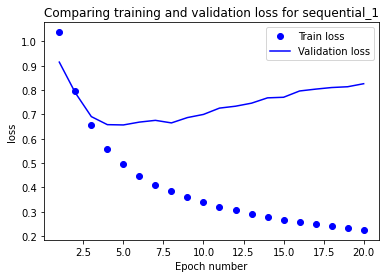

In [17]:
eval_metric(reg_model, reg_history, 'loss')

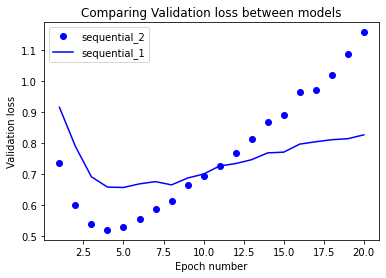

In [18]:
compare_models_by_metric(base_model, reg_model, base_history, reg_history, 'val_loss')

## Question 1

First identify (provide the name of) and then code the regularizer which is used in the following loss function:

$$cost = (\mathbf{y} - \mathbf{x}W)^2 + λ||W||$$

Let's assume $w = [-5, 4, -3, 2, 1]$

###  Answer 1

In [19]:
weights = [-5, 4, -3, 2, 1]

def l1_norm(weights):
    lambda_val = 0.1 # or any other value
    reg = lambda_val * sum(abs(w) for w in weights)
    return reg

print(l1_norm(weights))

1.5


## Question 2

First identify (provide the name of) and then code the regularizer which is used in the following loss function:

$$cost = (\mathbf{y} - \mathbf{x}W)^2 + λ||W||_2^2$$

Let's assume $w = [-5, 4, -3, 2, 1]$

###  Answer 2

In [20]:
import numpy as np

weights = [-5, 4, -3, 2, 1]
lmbda = 0.1

def l2_norm(weights):
    reg = lmbda * np.sum(np.square(weights))
    return reg

print(l2_norm(weights))



5.5


## Adding dropout layers
Add dropout
Dropout is one of the most effective and most commonly used regularization techniques for neural networks, developed by Hinton and his students at the University of Toronto.

The intuitive explanation for dropout is that because individual nodes in the network cannot rely on the output of the others, each node must output features that are useful on their own.

Dropout, applied to a layer, consists of randomly "dropping out" (i.e. set to zero) a number of output features of the layer during training. Let's say a given layer would normally have returned a vector [0.2, 0.5, 1.3, 0.8, 1.1] for a given input sample during training; after applying dropout, this vector will have a few zero entries distributed at random, e.g. [0, 0.5, 1.3, 0, 1.1].

The "dropout rate" is the fraction of the features that are being zeroed-out; it is usually set between 0.2 and 0.5. At test time, no units are dropped out, and instead the layer's output values are scaled down by a factor equal to the dropout rate, so as to balance for the fact that more units are active than at training time.

In `tf.keras` you can introduce dropout in a network via the Dropout layer, which gets applied to the output of layer right before.

Let's add two Dropout layers in our network to see how well they do at reducing overfitting:

In [21]:
drop_model = models.Sequential()
drop_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(64, activation='relu'))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(3, activation='softmax'))
drop_model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 64)                640064    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 3)                 195       
                                                                 
Total params: 644,419
Trainable params: 644,419
Non-trainable params: 0
_________________________________________________________________


In [22]:
drop_history = deep_model(drop_model, X_train_rest, y_train_rest, X_valid, y_valid)
drop_min = optimal_epoch(drop_history)

Epoch 1/20
24/24 [==============================] - 2s 58ms/step - loss: 0.8825 - accuracy: 0.6198 - val_loss: 0.7819 - val_accuracy: 0.6085
Epoch 2/20
24/24 [==============================] - 1s 46ms/step - loss: 0.7184 - accuracy: 0.6582 - val_loss: 0.6939 - val_accuracy: 0.6973
Epoch 3/20
24/24 [==============================] - 1s 48ms/step - loss: 0.6259 - accuracy: 0.7469 - val_loss: 0.6293 - val_accuracy: 0.7656
Epoch 4/20
24/24 [==============================] - 2s 86ms/step - loss: 0.5537 - accuracy: 0.7941 - val_loss: 0.5822 - val_accuracy: 0.7845
Epoch 5/20
24/24 [==============================] - 1s 61ms/step - loss: 0.4869 - accuracy: 0.8286 - val_loss: 0.5552 - val_accuracy: 0.7845
Epoch 6/20
24/24 [==============================] - 1s 48ms/step - loss: 0.4362 - accuracy: 0.8456 - val_loss: 0.5466 - val_accuracy: 0.7868
Epoch 7/20
24/24 [==============================] - 1s 47ms/step - loss: 0.4016 - accuracy: 0.8610 - val_loss: 0.5418 - val_accuracy: 0.7800
Epoch 8/20
24

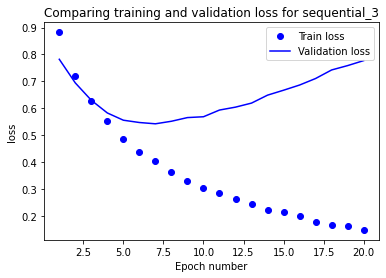

In [23]:
eval_metric(drop_model, drop_history, 'loss')


The model with dropout layers starts overfitting later than the baseline model. The loss also increases slower than the baseline model.



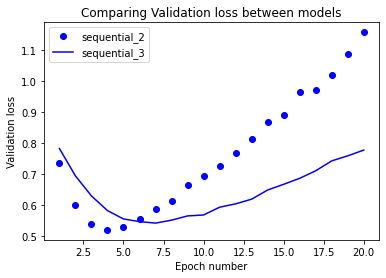

In [24]:
compare_models_by_metric(base_model, drop_model, base_history, drop_history, 'val_loss')


The model with the Dropout layers starts overfitting later. Compared to the baseline model the loss also remains much lower.



## Combined L2 + dropout

In [25]:
combined_model = tf.keras.Sequential([
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='relu', input_shape=(NB_WORDS,)),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3)
])


In [26]:
combined_history = deep_model(combined_model, X_train_rest, y_train_rest, X_valid, y_valid)
combined_min = optimal_epoch(combined_history)

Epoch 1/20
24/24 [==============================] - 10s 302ms/step - loss: 1.6269 - accuracy: 0.5954 - val_loss: 1.0990 - val_accuracy: 0.6039
Epoch 2/20
24/24 [==============================] - 8s 327ms/step - loss: 3.3019 - accuracy: 0.6706 - val_loss: 8.8385 - val_accuracy: 0.7307
Epoch 3/20
24/24 [==============================] - 7s 277ms/step - loss: 2.3830 - accuracy: 0.2716 - val_loss: 1.1386 - val_accuracy: 0.1373
Epoch 4/20
24/24 [==============================] - 8s 327ms/step - loss: 1.0416 - accuracy: 0.1305 - val_loss: 1.4044 - val_accuracy: 0.0933
Epoch 5/20
24/24 [==============================] - 8s 315ms/step - loss: 2.4172 - accuracy: 0.3333 - val_loss: 1.0411 - val_accuracy: 0.6039
Epoch 6/20
24/24 [==============================] - 7s 266ms/step - loss: 3.5011 - accuracy: 0.5762 - val_loss: 1.7888 - val_accuracy: 0.1351
Epoch 7/20
24/24 [==============================] - 8s 318ms/step - loss: 7.6601 - accuracy: 0.1223 - val_loss: 10.6514 - val_accuracy: 0.1973
Epoc

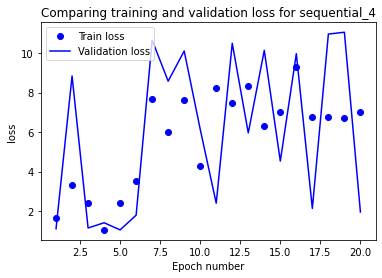

In [27]:
eval_metric(combined_model, combined_history, 'loss')


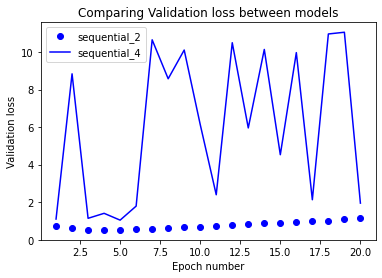

In [28]:
compare_models_by_metric(base_model, combined_model, base_history, combined_history, 'val_loss')


## Question 3

When does it make sense to add both L2 regularization and Dropout?

And what did doing so achieve in this case?


### Answer 3

* I think there is no definitive answer on when to use one or the other, or when to combine them.

* In this case, adding both L2 regularization and dropout improved the performance of the model by reducing overfitting. The validation loss stayed lower for longer, indicating that the model was better able to generalize to new data. Additionally, the accuracy on the validation set increased, indicating that the model was better able to correctly classify new data.

#Training on the full train data and evaluation on test dataAt first sight the reduced model seems to be the best model for generalization. But let's check that on the test set.

In [29]:
def test_model(model, X_train, y_train, X_test, y_test, epoch_stop):
  model.fit(X_train
              , y_train
              , epochs=epoch_stop
              , batch_size=BATCH_SIZE
              , verbose=1)
  results = model.evaluate(X_test, y_test)
  print()
  print('Test accuracy: {0:.2f}%'.format(results[1]*100))
  return results

In [30]:
base_results = test_model(base_model, X_train_oh, y_train_oh, X_test_oh, y_test_oh, base_min)


Epoch 1/4
26/26 [==============================] - 2s 75ms/step - loss: 0.1499 - accuracy: 0.9630
Epoch 2/4
26/26 [==============================] - 1s 46ms/step - loss: 0.0977 - accuracy: 0.9743
Epoch 3/4
26/26 [==============================] - 1s 43ms/step - loss: 0.0754 - accuracy: 0.9776
Epoch 4/4
46/46 [==============================] - 0s 4ms/step - loss: 0.9340 - accuracy: 0.7773

Test accuracy: 77.73%


In [31]:
reduced_model = models.Sequential()
reduced_model.add(layers.Dense(16, activation='relu', input_shape=(NB_WORDS,)))
reduced_model.add(layers.Dense(3, activation='softmax'))
reduced_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 16)                160016    
                                                                 
 dense_18 (Dense)            (None, 3)                 51        
                                                                 
Total params: 160,067
Trainable params: 160,067
Non-trainable params: 0
_________________________________________________________________


In [32]:
reduced_history = deep_model(reduced_model, X_train_rest, y_train_rest, X_valid, y_valid)
reduced_min = optimal_epoch(reduced_history)

Epoch 1/20
24/24 [==============================] - 2s 54ms/step - loss: 1.0402 - accuracy: 0.6067 - val_loss: 0.9855 - val_accuracy: 0.6677
Epoch 2/20
24/24 [==============================] - 1s 42ms/step - loss: 0.9305 - accuracy: 0.7075 - val_loss: 0.8930 - val_accuracy: 0.7056
Epoch 3/20
24/24 [==============================] - 1s 37ms/step - loss: 0.8312 - accuracy: 0.7360 - val_loss: 0.8109 - val_accuracy: 0.7291
Epoch 4/20
24/24 [==============================] - 1s 30ms/step - loss: 0.7428 - accuracy: 0.7551 - val_loss: 0.7426 - val_accuracy: 0.7360
Epoch 5/20
24/24 [==============================] - 1s 29ms/step - loss: 0.6670 - accuracy: 0.7732 - val_loss: 0.6860 - val_accuracy: 0.7466
Epoch 6/20
24/24 [==============================] - 1s 29ms/step - loss: 0.6042 - accuracy: 0.7908 - val_loss: 0.6430 - val_accuracy: 0.7618
Epoch 7/20
24/24 [==============================] - 1s 29ms/step - loss: 0.5533 - accuracy: 0.8132 - val_loss: 0.6082 - val_accuracy: 0.7724
Epoch 8/20
24

In [33]:
reduced_results = test_model(reduced_model, X_train_oh, y_train_oh, X_test_oh, y_test_oh, reduced_min)


Epoch 1/17
26/26 [==============================] - 1s 26ms/step - loss: 0.3029 - accuracy: 0.8975
Epoch 2/17
26/26 [==============================] - 1s 27ms/step - loss: 0.2916 - accuracy: 0.9029
Epoch 3/17
26/26 [==============================] - 1s 27ms/step - loss: 0.2810 - accuracy: 0.9065
Epoch 4/17
26/26 [==============================] - 1s 25ms/step - loss: 0.2709 - accuracy: 0.9108
Epoch 5/17
26/26 [==============================] - 1s 26ms/step - loss: 0.2614 - accuracy: 0.9148
Epoch 6/17
26/26 [==============================] - 1s 26ms/step - loss: 0.2525 - accuracy: 0.9177
Epoch 7/17
26/26 [==============================] - 1s 25ms/step - loss: 0.2444 - accuracy: 0.9208
Epoch 8/17
26/26 [==============================] - 1s 27ms/step - loss: 0.2364 - accuracy: 0.9238
Epoch 9/17
26/26 [==============================] - 1s 27ms/step - loss: 0.2288 - accuracy: 0.9268
Epoch 10/17
26/26 [==============================] - 1s 26ms/step - loss: 0.2215 - accuracy: 0.9287
Epoch 11/

In [34]:
reg_results = test_model(reg_model, X_train_oh, y_train_oh, X_test_oh, y_test_oh, reg_min)


Epoch 1/5
26/26 [==============================] - 1s 45ms/step - loss: 0.2818 - accuracy: 0.9467
Epoch 2/5
26/26 [==============================] - 1s 46ms/step - loss: 0.2497 - accuracy: 0.9570
Epoch 3/5
26/26 [==============================] - 1s 46ms/step - loss: 0.2353 - accuracy: 0.9645
Epoch 4/5
26/26 [==============================] - 1s 46ms/step - loss: 0.2254 - accuracy: 0.9658
Epoch 5/5
46/46 [==============================] - 0s 9ms/step - loss: 0.7329 - accuracy: 0.7876

Test accuracy: 78.76%


In [35]:
drop_results = test_model(drop_model, X_train_oh, y_train_oh, X_test_oh, y_test_oh, drop_min)


Epoch 1/7
26/26 [==============================] - 2s 72ms/step - loss: 0.2083 - accuracy: 0.9366
Epoch 2/7
26/26 [==============================] - 1s 45ms/step - loss: 0.1888 - accuracy: 0.9425
Epoch 3/7
26/26 [==============================] - 1s 46ms/step - loss: 0.1665 - accuracy: 0.9469
Epoch 4/7
26/26 [==============================] - 1s 45ms/step - loss: 0.1559 - accuracy: 0.9500
Epoch 5/7
26/26 [==============================] - 1s 45ms/step - loss: 0.1450 - accuracy: 0.9540
Epoch 6/7
26/26 [==============================] - 2s 64ms/step - loss: 0.1327 - accuracy: 0.9577
Epoch 7/7
46/46 [==============================] - 0s 5ms/step - loss: 0.7310 - accuracy: 0.8012

Test accuracy: 80.12%


# Handling Underfitting
* In a general situation, the best strategy is to increase the model complexity by either increasing the number of parameters of your deep learning model or the order of your model. Underfitting is due to the model being simpler than needed. It fails to capture the patterns in the data. Increasing the model complexity will lead to improvement in training performance. If we use a large enough model it can even achieve a training error of zero i.e. the model will memorize the data and suffer from over-fitting. The goal is to hit the optimal sweet spot.
* Try to train the model for more epochs. Ensure that the loss is decreasing gradually over the course of the training. Otherwise, it is highly likely that there is some kind of bug or problem in the training code/logic itself.
* If you aren’t shuffling the data after every epoch, it can harm the model performance. Ensuring that you are shuffling the data is a good check to perform at this point.

#Conclusion
To recap: here are the most common ways to prevent overfitting in neural networks:

* Get more training data.
* Reduce the capacity of the network.
* Add weight regularization.
* Add dropout.

Two important approaches not covered in this guide are:

* data-augmentation
* batch normalization

Remember that each method can help on its own, but often combining them can be even more effective.

here are the ways to prevent underfitting

* Get more training data.
* Increase the size or number of parameters in the model.
* Increase the complexity of the model.
* Increasing the training time, until cost function is minimised.


# Bonus content - Visualizing L2 regularization


In [36]:
import numpy as np
#%matplotlib notebook
%matplotlib inline
from IPython.core.debugger import set_trace
import warnings
warnings.filterwarnings('ignore')
import itertools

In [37]:
def plot_contour(f, x1bound, x2bound, resolution, ax):
    x1range = np.linspace(x1bound[0], x1bound[1], resolution)
    x2range = np.linspace(x2bound[0], x2bound[1], resolution)
    xg, yg = np.meshgrid(x1range, x2range)
    zg = np.zeros_like(xg)
    for i,j in itertools.product(range(resolution), range(resolution)):
        zg[i,j] = f([xg[i,j], yg[i,j]])
    ax.contour(xg, yg, zg, 100)
    return ax

Let's create a toy data:

In [38]:
N = 20
x = np.random.rand(N) * 10
y = -4*x + 10 + 2*np.random.randn(N)

visualize the regularized **cost function** 

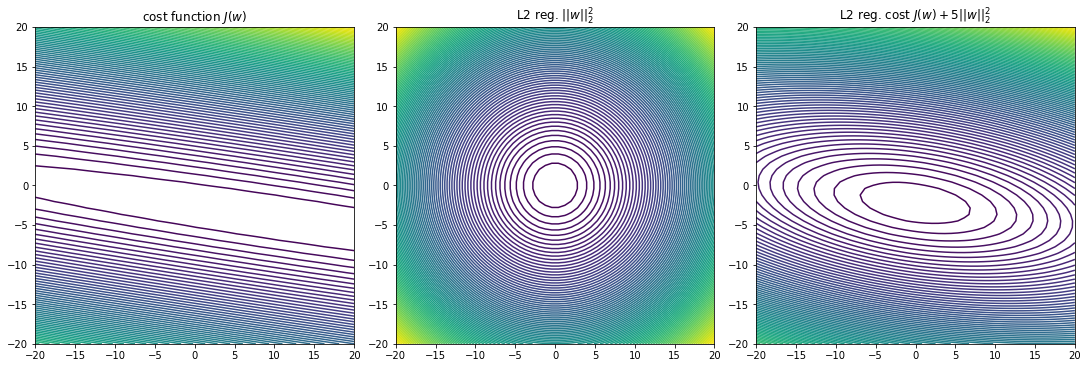

In [39]:
cost = lambda w: .5*np.mean((w[0] + w[1]*x - y)**2)
l2_penalty = lambda w: np.dot(w,w)/2
cost_plus_l2 = lambda w: cost(w) + 5*l2_penalty(w)

fig, axes = plt.subplots(ncols=3, nrows=1, constrained_layout=True, figsize=(15, 5))
plot_contour(cost, [-20,20], [-20,20], 50, axes[0])
axes[0].set_title(r'cost function $J(w)$')
plot_contour(l2_penalty, [-20,20], [-20,20], 50, axes[1])
axes[1].set_title(r'L2 reg. $||w||_2^2$')
plot_contour(cost_plus_l2, [-20,20], [-20,20], 50, axes[2])
axes[2].set_title(r'L2 reg. cost $J(w) + 5 ||w||_2^2$')
plt.show()

## Bonus question: Plot the same for L1 regularization 

### Answer 

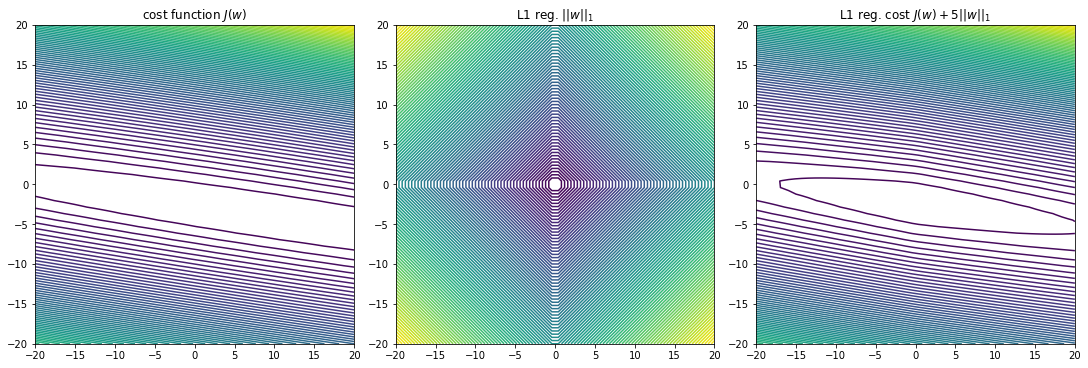

In [40]:
cost = lambda w: .5*np.mean((w[0] + w[1]*x - y)**2)
l1_penalty = lambda w: np.sum(np.abs(w))
cost_plus_l1 = lambda w: cost(w) + 5*l1_penalty(w)

fig, axes = plt.subplots(ncols=3, nrows=1, constrained_layout=True, figsize=(15, 5))
plot_contour(cost, [-20,20], [-20,20], 50, axes[0])
axes[0].set_title(r'cost function $J(w)$')
plot_contour(l1_penalty, [-20,20], [-20,20], 50, axes[1])
axes[1].set_title(r'L1 reg. $||w||_1$')
plot_contour(cost_plus_l1, [-20,20], [-20,20], 50, axes[2])
axes[2].set_title(r'L1 reg. cost $J(w) + 5 ||w||_1$')
plt.show()


## Bonus Question 2
After looking at the visualization to what the L1 and L2 normalizations, how do they help while training?

L1 and L2 regularization methods are used to prevent overfitting in neural networks by adding a penalty term to the cost function. L2 regularization encourages the model to use all inputs in the prediction by shrinking the weights towards zero, while L1 regularization can result in some weights becoming exactly zero, effectively performing feature selection. Both methods help in reducing overfitting by controlling the complexity of the model, but the choice between them depends on the specific problem and data characteristics.